In [1]:
import sys
import os

In [2]:
from importlib import reload
from os.path import join, splitext, sep, dirname
from collections import defaultdict
import sys
import numpy as np
import cv2
cv2.setNumThreads(1)
import os
import itertools
import h5py
from scipy.spatial.transform import Rotation
import zipfile
import io
import scipy.io
import tqdm
from PIL import Image
from IPython.display import display

In [3]:
import torch
from torch.utils.data import Dataset

In [4]:
import trackertraincode.neuralnets.models
import trackertraincode.neuralnets.modelcomponents
import trackertraincode.utils as utils

In [5]:
from trackertraincode.datasets.preprocessing import imdecode,\
    depth_centered_keypoints, \
    extract_image_roi
from scripts.export_model import clear_denormals

In [6]:
modelfile = '../model_files/pub_synface_oroi/run2/swa_NetworkWithPointHead_mobilenetv1.ckpt'
net = trackertraincode.neuralnets.models.NetworkWithPointHead(
    enable_point_head=True,
    config='mobilenetv1', 
    enable_uncertainty=True)
net.load_state_dict(torch.load(modelfile))
inputsize = net.input_resolution
net.cuda()
net.eval()

In [7]:
def unnormalize_coords(size_input, coords):
    h, w = size_input
    coords = coords.copy()
    coords[...,0] += 1.
    coords[...,0] *= w*0.5
    coords[...,1] += 1.
    coords[...,1] *= h*0.5
    coords[...,2] *= 0.25*(h+w)
    return coords

def is_sample_file(fn):
    return splitext(fn)[1]=='.mat' and not fn.endswith(sep) \
        and dirname(fn)=='AFLW2000'

def discover_samples(zf):
    filenames = [ 
        f.filename for f in zf.filelist if is_sample_file(f.filename)  ]
    return filenames


class AFLW2k3D(Dataset):
    def __init__(self, zipfilename, crop = 'center'):
        self.zipfilename = zipfilename
        with zipfile.ZipFile(zipfilename) as zf:
            self.matfilenames = sorted(discover_samples(zf))
        self.zipfile = None
        self.crop = crop
    
    def __len__(self):
        return len(self.matfilenames)

    def __getitem__(self, i):
        if self.zipfile is None:
            self.zipfile = zipfile.ZipFile(self.zipfilename)
        
        matfile = self.matfilenames[i]
        with io.BytesIO(self.zipfile.read(matfile)) as f:
            data = scipy.io.loadmat(f)

        assert all((k in data) for k in 'pt3d_68 Pose_Para'.split()), f"Data not found in file {matfile}. Contents is {data.keys()}"

        jpgbuffer = self.zipfile.read(splitext(matfile)[0]+'.jpg')
        img = imdecode(jpgbuffer, color=False)
        
        H, W = img.shape[:2]

        if self.crop == 'center':
            roi = np.array([ W//4, H//4, W*3//4, H*3//4 ])
            img = extract_image_roi(img, roi, 0.1, True, return_offset=False)
        else:
            pt3d = depth_centered_keypoints(data['pt3d_68'])
            # Include some of the forehead in the bounding box. If the model has not been trained on this, it will decrease accuracy drastically!
            # Including a larger area of the heads seems to be beneficial for size predictions. But for angle predictions can be good so or so.
            #pt3d = extended_key_points_for_bounding_box(pt3d.T).T
            x0, y0, _ = np.amin(pt3d, axis=1)
            x1, y1, _ = np.amax(pt3d, axis=1)
            roi = np.array([x0, y0, x1, y1])
            img = extract_image_roi(img,roi, 0.1, True, return_offset=False)
        
        img = cv2.resize(img, (inputsize, inputsize))
        
        pitch, yaw, roll, tx, ty, tz, scale = data['Pose_Para'][0]
        
        return img, np.array([pitch, yaw, roll])


def visualize(ds, range_):
    for i in range_:
        img, rot = ds[i]
        display(Image.fromarray(img))
        print (rot*180/np.pi)

In [8]:
def measure_and_report(aflw2k3d, net):
    predicted = []
    euler_rot_targets = []
    indices = []
    filtered = []

    for i, (img, label) in enumerate(tqdm.tqdm(aflw2k3d)):
        euler_rot = label
        pose_para_degrees = euler_rot*180./np.pi

        # Following the img2pose paper
        if np.any(np.abs(pose_para_degrees) > 99):
            filtered.append((i, pose_para_degrees))
            continue        

        H, W = img.shape[:2]

        with torch.no_grad():
            input_ = torch.from_numpy(img/255.0 - 0.5).float().cuda()[None,None,...]
            output = net(input_)
        if isinstance(output, dict):
            pose, coord = output['pose'], output['coord']
        else:
            coord, pose, _ ,_, _ = output
        output = {
            'rotation' : utils.convert_to_rot(pose.cpu().numpy())[0],
            'coord' : unnormalize_coords((H,W), coord.cpu().numpy())[0],
        }

        predicted.append(output)
        euler_rot_targets.append(euler_rot)
        indices.append(i)

    print (f"Number of item actually processed: {len(predicted)}")
    
    if 0:
        print (f"Filtered {len(filtered)} items:")
        for i, pose_para_degrees in filtered:
            print (f"Filter bad {aflw2k3d.matfilenames[i]} with pose params: {pose_para_degrees}")
        
    predicted_euler = np.array([utils.inv_aflw_rotation_conversion(p['rotation']) for p in predicted])
    mae_euler = np.average(np.abs(predicted_euler - np.array(euler_rot_targets)), axis=0)
    mae_euler *= 180 / np.pi
    
    quats_targets = np.asarray([utils.aflw_rotation_conversion(*eulers).as_quat() for eulers in euler_rot_targets ])
    quats_predict = np.asarray([p['rotation'].as_quat() for p in predicted])
    delta_rot = (Rotation.from_quat(quats_targets).inv() * Rotation.from_quat(quats_predict)).magnitude()
    mae_rot_angle = np.mean(delta_rot)*180./np.pi

    print ("MAE pitch: {:0.3f}°, yaw: {:0.3f}°, roll: {:0.3f}°, average: {:0.3f}°, geodesic: {:0.3f}°".format(*mae_euler,np.average(mae_euler),mae_rot_angle))

In [9]:
aflw2k3d = AFLW2k3D(join(os.environ['ORIGINAL_DATA_DIR'],'AFLW2000-3D.zip'))

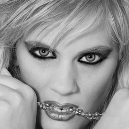

[-22.874239    1.044306    4.9088855]


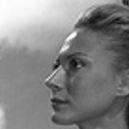

[26.932741 68.155235 17.24367 ]


In [10]:
visualize(aflw2k3d, range(2))

In [11]:
print ("Evaluation on center crops")
measure_and_report(aflw2k3d, net)

Evaluation on center crops


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 184.43it/s]


Number of item actually processed: 1969
MAE pitch: 4.368°, yaw: 2.788°, roll: 2.622°, average: 3.259°, geodesic: 5.340°


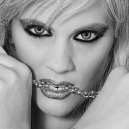

[-22.874239    1.044306    4.9088855]


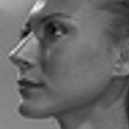

[26.932741 68.155235 17.24367 ]


In [12]:
aflw2k3d = AFLW2k3D(join(os.environ['ORIGINAL_DATA_DIR'],'AFLW2000-3D.zip'), crop='bbox')
visualize(aflw2k3d, range(2))

In [13]:
print ("Evaluation on bounding box crops")
measure_and_report(aflw2k3d, net)

Evaluation on bounding box crops


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 251.90it/s]


Number of item actually processed: 1969
MAE pitch: 4.167°, yaw: 2.737°, roll: 2.411°, average: 3.105°, geodesic: 5.223°
